# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 6
# Reg-Logistic Regression, ROC, and Data Imputation

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A): 209A

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display
%matplotlib inline

import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

sns.set_context('poster')

## Automated Breast Cancer Detection

In this homework, we will consider the problem of early breast cancer detection from X-ray images. Specifically, given a candidate region of interest (ROI) from an X-ray image of a patient's breast, the goal is to predict if the region corresponds to a malignant tumor (label 1) or is normal (label 0). The training and test data sets for this problem is provided in the file `hw6_dataset.csv`. Each row in these files corresponds to a ROI in a patient's X-ray, with columns 1-117 containing features computed using standard image processing algorithms. The last column contains the class label, and is based on a radiologist's opinion or a biopsy. This data was obtained from the KDD Cup 2008 challenge.

The data set contain a total of 69,098 candidate ROIs, of which only 409 are malignant, while the remaining are all normal. 

*Note*: be careful of reading/treating column names and row names in this data set.

## Question 1: Beyond Classification Accuracy


0.  Split the data set into a training set and a testing set.  The training set should be 75% of the original data set, and the testing set 25%.  Use `np.random.seed(9001)`.

1. Fit a logistic regression classifier to the training set and report the  accuracy of the classifier on the test set. You should use $L_2$ regularization in logistic regression, with the regularization parameter tuned using cross-validation. 
    1. How does the fitted model compare with a classifier that predicts 'normal' (label 0) on all patients? 
    2. Do you think the difference in the classification accuracies are large enough to declare logistic regression as a better classifier than the all 0's classifier? Why or why not?
    
For applications with imbalanced class labels, in this case when there are many more healthy subjects ($Y=0$) than those with cancer ($Y=1$), the classification accuracy may not be the best metric to evaluate a classifier's performance. As an alternative, we could analyze the confusion table for the classifier. 

<ol start="3">
<li> Compute the confusion table for both the fitted classifier and the classifier that predicts all 0's.</li>
<li> Using the entries of the confusion table compute the *true positive rate* and the *true negative rate* for the two classifiers. Explain what these evaluation metrics mean for the specific task of cancer detection. Based on the observed metrics, comment on whether the fitted model is better than the all 0's classifier.</li>
<li> What is the *false positive rate* of the fitted classifier, and how is it related to its true positive and true negative rate? Why is a classifier with high false positive rate undesirable for a cancer detection task?</li>
</ol>
*Hint:* You may use the `metrics.confusion_matrix` function to compute the confusion matrix for a classification model.

In [3]:
# 1

np.random.seed(9001)
df = pd.read_csv('data/hw6_dataset.csv', header=None)
msk = np.random.rand(len(df)) < 0.75
data_train = df[msk]
data_test = df[~msk]

In [4]:
print(data_train.shape)
print(data_test.shape)

(52009, 118)
(17089, 118)


In [6]:
X_train

array([[-0.144  , -0.143  , -0.116  , ...,  0.553  , -0.417  ,  0.256  ],
       [ 0.215  , -0.184  ,  0.0274 , ...,  0.363  ,  0.326  , -0.0528 ],
       [ 0.00922, -0.138  ,  0.169  , ...,  0.55   , -0.284  ,  0.155  ],
       ..., 
       [ 0.136  ,  0.186  ,  0.0736 , ..., -0.219  ,  0.549  , -0.373  ],
       [ 0.0559 ,  0.201  ,  0.212  , ...,  0.474  ,  1.1    , -0.212  ],
       [-0.0988 ,  0.185  , -0.317  , ...,  0.0308 ,  0.456  , -0.394  ]])

In [5]:
# 2

from sklearn.preprocessing import StandardScaler

X_train = data_train.iloc[:, :-1].values
y_train = data_train.iloc[:, -1].values
X_test = data_test.iloc[:, :-1].values
y_test = data_test.iloc[:, -1].values

# Standardize

scaler = StandardScaler().fit(X_train)
X_train_normed = scaler.transform(X_train)
X_test_normed = scaler.transform(X_test)

# Fitting

logitm = LogisticRegressionCV(penalty='l2').fit(X_train_normed, y_train)

KeyboardInterrupt: 

In [5]:
y_test_pred = logitm.predict(X_test_normed)
test_score = accuracy_score(y_test, y_test_pred)
print('The accuracy of the logistic regression classifier on the test set is {}.'.format(test_score))
print('The accuracy of the classifier predicting \'normal\' on all patients on the test set is {}.'.\
     format(np.mean(y_test==0)))
print('The increase in accuracy on the test set (by percentage) is {}.'.\
      format((test_score-np.mean(y_test==0))/np.mean(y_test==0)))

The accuracy of the logistic regression classifier on the test set is 0.995026040142782.
The accuracy of the classifier predicting 'normal' on all patients on the test set is 0.9942067996957107.
The increase in accuracy on the test set (by percentage) is 0.0008240141259564976.


A. The accuracy of the logistic regression classifier on the test set is slightly better than the classifier predicting 'normal' on all patients (by 0.082%).

B. We don't think the difference in the classification accuracies is large enough to declare logistic regression as a better classifier than the all 0's classifier since the difference is too small (only 0.082%). The reason is that non-zero samples are too small. The class labels are imbalanced, which indicates other metrics (such as false positive rate and false negative rate) might provide better evaluation for the models. 

In [6]:
# 3

from sklearn.metrics import confusion_matrix

y_test_pred2 = np.zeros_like(y_test)

cm1 = confusion_matrix(y_test, y_test_pred)
cm2 = confusion_matrix(y_test, y_test_pred2)
print('The confusion table for the fitted classifier is {}.'.format(cm1))
print('The confusion table for the classifier that predicts all 0s is {}.'.format(cm2))

The confusion table for the fitted classifier is [[16984     6]
 [   79    20]].
The confusion table for the classifier that predicts all 0s is [[16990     0]
 [   99     0]].


In [7]:
# 4

def cal_tpr(cm):
    return cm[1, 1] / (cm[1, 0] + cm[1, 1])

def cal_tnr(cm):
    return cm[0, 0] / (cm[0, 0] + cm[0, 1])

print('The fitted classifier: true positive rate {}; true negative rate {}.'.format(cal_tpr(cm1), cal_tnr(cm1)))
print('The classifier that predicts all 0s: true positive rate {}; true negative rate {}.'.\
      format(cal_tpr(cm2), cal_tnr(cm2)))

The fitted classifier: true positive rate 0.20202020202020202; true negative rate 0.9996468510888759.
The classifier that predicts all 0s: true positive rate 0.0; true negative rate 1.0.


In this case, true positive rate means the percentage of malignant tumors that have been correctly predicted (among all cancer patients); true negative rate means the percentage of normal patients that have been correctly predicted (among all normal patients).

Based on the observed metrics, the fitted model is better than the all 0s classifier since the true positive rate is much higher, which means more cancer patients are diagnosed while no cancer patients could be diagnosed through the classifier predicting 0s for all patients.

In [8]:
# 5

def cal_fpr(cm):
    return cm[0, 1] / (cm[0, 0] + cm[0, 1])

print('The fitted classifier: false positive rate {}.'.format(cal_fpr(cm1)))

The fitted classifier: false positive rate 0.0003531489111241907.


The false positive rate of the fitted classifier is shown above. 
$$False\ Positive\ Rate = \frac{\sum False\ Positive}{\sum Condition\ Positive}; 
True\ Positive\ Rate = \frac{\sum True\ Positive}{\sum Condition\ Negative},$$
which means the relation between false positive rate and true positive rate depends on the number of actual positives and negatives in sample, as well as the number of true positive and false positive.
$$False\ Positive\ Rate = 1 - True\ Negative\ Rate.$$

It is also equal to the $$\frac{total \ number \ label \ as \ true (1) - true \ positive}{total \ number \ of \ actually \ false(0)}$$

A classifier with high false positive rate means many healthy people would be misdiagnosed as cancer patients. It is thus undersirable since it might treat the normal patients wrongly, increase the burden of hospital and unnecessary worriness of patients.

## Question 2: ROC Analysis

Another powerful diagnostic tool for class-imbalanced classification tasks is the Receiver Operating Characteristic (ROC) curve. Notice that the default logistic regression classifier in `sklearn` classifies a data point by thresholding the predicted class probability $\hat{P}(Y=1)$ at 0.5. By using a different threshold, we can adjust the trade-off between the true positive rate (TPR) and false positive rate (FPR) of the classifier. The ROC curve allows us to visualize this trade-off across all possible thresholds.


1. Display the ROC curve for the fitted classifier on the *test set*. In the same plot, also display the ROC curve for the all 0's classifier. How do the two curves compare?

2.  Compute the highest TPR that can be achieved by the classifier at each of the following FPR's, and the thresholds at which they are achieved. Based on your results, comment on how the threshold influences a classifier's FPR.
    - FPR = 0
    - FPR = 0.1
    - FPR = 0.5
    - FPR = 0.9
- Suppose a clinician told you that diagnosing a cancer patient as normal is *twice* as critical an error as diagnosing a normal patient as having cancer. Based on this information, what threshold would you recommend the clinician to use? What is the TPR and FPR of the classifier at this threshold? 

- Compute the area under the ROC curve (AUC) for both the fitted classifier and the all 0's classifier. How does the difference in the AUCs of the two classifiers compare with the difference between their classification accuracies in Question 1, Part 2(A)? 

*Hint:* You may use the `metrics.roc_curve` function to compute the ROC curve for a classification model and the `metrics.roc_auc_score` function to compute the AUC for the model.

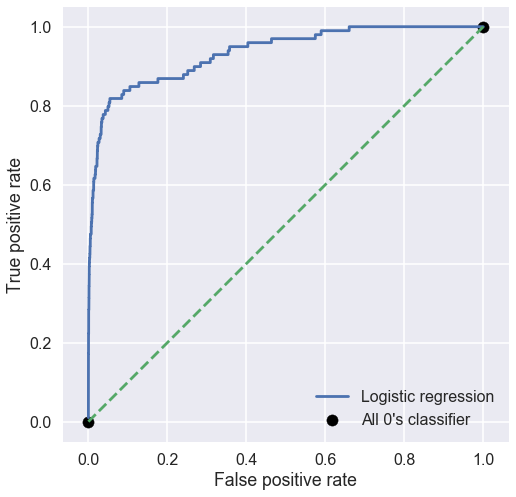

In [9]:
# 1

from sklearn import metrics

y_test_proba = logitm.predict_proba(X_test_normed)[:, 1]
fpr1, tpr1, thres1 = metrics.roc_curve(y_test, y_test_proba, drop_intermediate=False)


y_test_s2 = np.zeros_like(y_test)
fpr2, tpr2, thres2 = metrics.roc_curve(y_test, y_test_s2, drop_intermediate=False)

plt.figure(figsize=(8, 8))
plt.plot(fpr1, tpr1, label='Logistic regression');
plt.scatter(fpr2, tpr2, color='k', label='All 0\'s classifier');
plt.plot([0, 1], [0, 1], '--');
plt.xlabel('False positive rate');
plt.ylabel('True positive rate');
plt.legend();
plt.axis('equal');

As we can see, the ROC curve for the fitted classifier approaches the upper left corner, which corresponds to the best possible prediction result, at some thresholds, while the ROC curve for the all 0's classifier contains only 2 points , which are (0, 0) and (1, 1). All 0's classifier could flip only by thresholding $\hat{P}(Y=1)$ at 0, which becomes all 1's classifier and reaches a true positive rate of 1 at the cost of false positive rate of 1; both true positive rate and false positive rate are 0 for any other thresholds.

In [10]:
# 2

def best_tpr(fpr, fpr_=fpr1, tpr_=tpr1, thres_=thres1):
    i = np.argmax(tpr_[fpr_==fpr])
    btpr = tpr_[fpr_==fpr][i]
    bthres = thres_[fpr_==fpr][i]
    return btpr, bthres

fprs = [0, 0.1, 0.5, 0.9]
for fpr in fprs:
    btpr, bthres = best_tpr(fpr)
    print('When FPR = {}, the highest TPR is {} by thresholding at {}.'.format(fpr, btpr, bthres))

When FPR = 0, the highest TPR is 0.08080808080808081 by thresholding at 0.9403685975225237.
When FPR = 0.1, the highest TPR is 0.8383838383838383 by thresholding at 0.0062472431097789.
When FPR = 0.5, the highest TPR is 0.9696969696969697 by thresholding at 0.00020945428351840822.
When FPR = 0.9, the highest TPR is 1.0 by thresholding at 2.4854580327236744e-06.


A classifier's FPR increases as the threshold decreases, since each sample is more likely to be labeled as "positive" when the threshold decreases.

Q3. If diagnosing a cancer patient as normal is twice as critical an error as diagnosing a normal patient as having cancer, we can define the loss function as $2\times FNR + FPR = 2\times (1-TPR) + FPR$.

In [11]:
# 3

def loss_function(fpr, tpr):
    return 2 * (1 - tpr) + fpr

loss = loss_function(fpr1, tpr1)
i = np.argmin(loss)
print('The recommended threshold is {}; the corresponding TPR is {}; the corresponding FPR is {}.'.\
     format(thres1[i], tpr1[i], fpr1[i]))

The recommended threshold is 0.005752301144082792; the corresponding TPR is 0.8484848484848485; the corresponding FPR is 0.10512065921130076.


In [12]:
# 4

from sklearn.metrics import roc_auc_score

auc1 = roc_auc_score(y_test, y_test_proba)
auc2 = roc_auc_score(y_test, y_test_s2)

print('The AUC for the fitted classifier is {}.'.format(auc1))
print('The AUC for the all 0\'s classifier is {}.'.format(auc2))

The AUC for the fitted classifier is 0.9346353469955588.
The AUC for the all 0's classifier is 0.5.


The AUC for the fitted classifier is significantly better than that for the all 0's classifier, while there is no significant difference between their classification accuracies in Question 1, Part 2(A). 

The ROC curve of fitted model looks better. Also, its AUC is close to the accuracy in Question 1. However, AUC of all 0's classifier is much less than accuracy in Question 1. This infers that using ROC/AUC might be a better measure to assess a model rather than simply looking at accuracy.

## Question 3: Missing data

In this problem you are given a different data set, `hw6_dataset_missing.csv`, that is  similar to the one you used above (same column definitions and same conditions), however this data set contains missing values. 

*Note*: be careful of reading/treating column names and row names in this data set as well, it *may* be different than the first data set.


1. Remove all observations that contain and missing values, split the dataset into a 75-25 train-test split, and fit the regularized logistic regression as in Question 1 (use `LogisticRegressionCV` again to retune).  Report the overall classification rate and TPR in the test set.
2. Restart with a fresh copy of the data in `hw6_dataset_missing.csv` and impute the missing data via mean imputation.  Split the data 75-25 and fit the regularized logistic regression model.  Report the overall classification rate and TPR in the test set.  
3. Again restart with a fresh copy of the data in `hw6_dataset_missing.csv` and impute the missing data via a model-based imputation method. Once again split the data 75-25 and fit the regularized logistic regression model.  Report the overall classification rate and TPR in the test set.  
4. Compare the results in the 3 previous parts of this problem.  Prepare a paragraph (5-6 sentences) discussing the results, the computational complexity of the methods, and conjecture and explain why you get the results that you see.



In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [14]:
# 1

df = pd.read_csv('HW6_dataset_missing.csv')
df = df.drop('Unnamed: 0', 1)
print(df.shape)
df = df.dropna(how='any')
print(df.shape)
print(np.sum(df.iloc[:, -1] == 1))

(24999, 118)
(1436, 118)
3


In [15]:
np.random.seed(9001)
msk = np.random.rand(len(df)) < 0.75
data_train = df[msk]
data_test = df[~msk]

X_train = data_train.iloc[:, :-1].values
y_train = data_train.iloc[:, -1].values
X_test = data_test.iloc[:, :-1].values
y_test = data_test.iloc[:, -1].values

# Standardize

scaler = StandardScaler().fit(X_train)
X_train_normed = scaler.transform(X_train)
X_test_normed = scaler.transform(X_test)

# Fitting

logitm = LogisticRegressionCV(penalty='l2').fit(X_train_normed, y_train)

y_test_pred = logitm.predict(X_test_normed)
test_score = accuracy_score(y_test, y_test_pred)
cm = confusion_matrix(y_test, y_test_pred)
def cal_tpr(cm):
    return cm[1, 1] / (cm[1, 0] + cm[1, 1])
print('The accuracy on the test set is {}.'.format(test_score))
print('The TPR on the test set is {}.'.format(cal_tpr(cm)))

y_test_proba = logitm.predict_proba(X_test_normed)[:, 1]
auc = roc_auc_score(y_test, y_test_proba)
print('The AUC on the test set is {}.'.format(auc))

The accuracy on the test set is 0.9943820224719101.
The TPR on the test set is 0.0.
The AUC on the test set is 0.8008474576271186.


/Users/wyssuser/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


In [16]:
# 2

df = pd.read_csv('HW6_dataset_missing.csv')
df = df.drop('Unnamed: 0', 1)
print(df.shape)

# mean imputation
df = df.fillna(df.mean())

(24999, 118)


In [17]:
np.random.seed(9001)
msk = np.random.rand(len(df)) < 0.75
data_train = df[msk]
data_test = df[~msk]

X_train = data_train.iloc[:, :-1].values
y_train = data_train.iloc[:, -1].values
X_test = data_test.iloc[:, :-1].values
y_test = data_test.iloc[:, -1].values

# Standardize

scaler = StandardScaler().fit(X_train)
X_train_normed = scaler.transform(X_train)
X_test_normed = scaler.transform(X_test)

# Fitting

logitm = LogisticRegressionCV(penalty='l2').fit(X_train_normed, y_train)

y_test_pred = logitm.predict(X_test_normed)
test_score = accuracy_score(y_test, y_test_pred)
cm = confusion_matrix(y_test, y_test_pred)
def cal_tpr(cm):
    return cm[1, 1] / (cm[1, 0] + cm[1, 1])
print('The accuracy on the test set is {}.'.format(test_score))
print('The TPR on the test set is {}.'.format(cal_tpr(cm)))

y_test_proba = logitm.predict_proba(X_test_normed)[:, 1]
auc = roc_auc_score(y_test, y_test_proba)
print('The AUC on the test set is {}.'.format(auc))

The accuracy on the test set is 0.9929795918367347.
The TPR on the test set is 0.19607843137254902.
The AUC on the test set is 0.8370005229619012.


In [18]:
# 3

df = pd.read_csv('HW6_dataset_missing.csv')
df = df.drop('Unnamed: 0', 1)
print(df.shape)
print('The number of missing values in the class label column is {}.'.format(sum(df.iloc[:, -1].isnull())))

# Find columns with missing data
cols_intact = []
cols_missing = []
for i in range(df.shape[1] - 1):
    if sum(df.iloc[:, i].isnull()) > 0:
        cols_missing.append(i)
    else:
        cols_intact.append(i)

print('The number of columns without missing values (not including the class label column) is {}.'.\
      format(len(cols_intact)))
print('The number of columns with missing values is {}.'.format(len(cols_missing)))

(24999, 118)
The number of missing values in the class label column is 0.
The number of columns without missing values (not including the class label column) is 100.
The number of columns with missing values is 17.


Most columns don't contain any missing value; we can thus impute missing values by fitting a Ridge regression model on these intact columns and plugging in predicted values plus randomness.

In [19]:
def impute(i, df=df, cols_intact=cols_intact):
    X_imp = df.iloc[:, cols_intact]
    y_imp = df.iloc[:, i]
    X_reg = X_imp[~y_imp.isnull()]
    y_reg = y_imp[~y_imp.isnull()]
    
    regress = RidgeCV().fit(X_reg, y_reg)
    y_hat = regress.predict(X_imp)
    y_reg_pred = y_hat[~y_imp.isnull()]
    
    y_missing = y_hat[y_imp.isnull()]
    y_missing_noise = y_missing + np.random.normal(loc=0, scale=np.sqrt(mean_squared_error(y_reg, y_reg_pred)), \
                                                   size=y_missing.shape[0])
    missing_series = pd.Series(data=y_missing_noise, index=y_imp[y_imp.isnull()].index)
    df.iloc[:, i] = df.iloc[:, i].fillna(missing_series)
    return df

for i in cols_missing:
    df = impute(i, df)

In [20]:
np.random.seed(9001)
msk = np.random.rand(len(df)) < 0.75
data_train = df[msk]
data_test = df[~msk]

X_train = data_train.iloc[:, :-1].values
y_train = data_train.iloc[:, -1].values
X_test = data_test.iloc[:, :-1].values
y_test = data_test.iloc[:, -1].values

# Standardize

scaler = StandardScaler().fit(X_train)
X_train_normed = scaler.transform(X_train)
X_test_normed = scaler.transform(X_test)

# Fitting

logitm = LogisticRegressionCV(penalty='l2').fit(X_train_normed, y_train)

y_test_pred = logitm.predict(X_test_normed)
test_score = accuracy_score(y_test, y_test_pred)
cm = confusion_matrix(y_test, y_test_pred)
def cal_tpr(cm):
    return cm[1, 1] / (cm[1, 0] + cm[1, 1])
print('The accuracy on the test set is {}.'.format(test_score))
print('The TPR on the test set is {}.'.format(cal_tpr(cm)))

y_test_proba = logitm.predict_proba(X_test_normed)[:, 1]
auc = roc_auc_score(y_test, y_test_proba)
print('The AUC on the test set is {}.'.format(auc))

The accuracy on the test set is 0.9929795918367347.
The TPR on the test set is 0.17647058823529413.
The AUC on the test set is 0.84705301284162.


#### Q4 answer:
**Results**: the classification accuracies are very similar for 3 methods; the accuracy of the first method is slightly higher than that of other 2 methods, which is mainly due to smaller sample size. The TPR for the first method is 0, while the TPRs for the other 2 methods are between 0.15 and 0.2 ,where the TPR for the mena imputation method is slightly higher. The AUC for the mean imputation method is higher than that of the first one; the AUC for the model imputation is higher than that of the mean imputation method.

**Computational complexity**: let $N$ be the number of samples and $C$ be the number of features. It takes $O(CN)$ to either drop the observations that contain missing values or perform mean imputation; it takes $O(C^2N)$ to impute missing values for a single column through linear regression (the coefficient and thus the time cost here for the 3rd method is higher due to regularization and cross validation cost). The computational costs of logistic regression for the 2nd and 3rd imputation methods are the same, while the computational cost (in terms of both time and space) of logistic regression for the 1st method is much lower since the leftover sample size is significantly lower.

**Discussion**: the sample size after removing missing values is significantly lower (by an order of magnitude) and there are only 3 samples with positive labels left in total; as a result, both the classification model and the classification result are very sensitive to the noise in these 3 samples, and the TPR would be 0 if none of these samples is predicted correctly. Therefore, it is not a good idea to remove missing values here. The difference in TPRs for the mean imputation and the model imputation might be caused by the choice of the threshold (we chose the default threshold here) since the AUC score for the model imputation method is higher than that of the mean imputation method while the TPR is lower. Higher AUC score for the model imputation method indicates better performance of the 3rd method. The mean imputation could easily deviate from real data since the same value is used for different observations; the result that it gets better performance than dropping missing values might be simply due to the fact that it keeps all the observations since the features from intact columns, which dominate the feature space, could contribute significantly to the classification. The model imputation method, which used Ridge regression with uncertainty, mimicking real data better than the mean imputation, thus gets the best AUC score.

## APCOMP209a - Homework Question


This problem walks you through the derivation of the **likelihood equations** for a generalized linear model (GLM). Suppose that the random component of the GLM is in the univariate natural exponential family, so that
$$f(y_i|\theta_i) = h(y_i) e^{y_i\theta_i - b(\theta_i)}$$
Define the individual log-likelihood for each observation $i$ as
$$l_i(\theta_i) \equiv \log f(y_i|\theta_i)$$
with linear predictor
$$\eta_i = x_i^T\beta = g(\mu_i)$$
for some link function $g$ and where $\mu_i=E(Y_i)$.

1. Use the above expressions to write a simplified expression for the log-likelihood $l(\theta)$ for the entire dataset, $y_1, \dots, y_n$.

2. Use the chain rule to express $\frac{\partial l_i}{\partial \beta_j}$ in terms of the derivatives of $l_i, \theta_i, \mu_i$, and $\eta_i$. (*Hint*: Think carefully about which variables are related to which, and in what way. For example, for which of the above variables do you know the derivative with respect to $\beta_j$?)

3. Compute the derivatives for $\frac{\partial l_i}{\partial \theta_i}$ and $\frac{\partial \eta_i}{\partial \beta_j}$.

4. Express $\mu_i$ in terms of $\theta_i$, and use this relationship to compute $\frac{\partial \theta_i}{\partial \mu_i}$. (\emph{Hint}: Recall the cumulant function of a natural exponential family, and assume that you can write $\partial f/\partial g = (\partial g / \partial f)^{-1}$.)

5. Express $\eta_i$ in terms of $\mu_i$. Using the same hint as the above, compute $\frac{\partial \mu_i}{\partial \eta_i}$.

6. Put all of the above parts together to write an expression for $\frac{\partial l}{\partial \beta_j}$. Use matrix notation to write this expression as
$$\nabla_{\beta} l(\beta) = XDV^{-1}(Y - \mu) = 0$$
That is, compute the matrices $D$ and $V$ such that this equation holds.

7. If we use the canonical link function, how do your answers to part (6) simplify?

8. Finally, compute the above likelihood equations in the case of logistic regression, and show that this is equivalent to the solution given in lecture.


1. $l_i(\theta_i) = \log f(y_i|\theta_i) = \log h(y_i)e^{y_i\theta_i - b(\theta_i)} = \log h(y_i) + \log (y_i\theta_i - b(\theta_i))$, $l(\theta) = \sum_i l_i(\theta_i)$

2. $$\frac{\partial l_i}{\partial \beta_j} = \frac{\partial l_i}{\partial \mu_i} \frac{\partial \theta_i}{\partial \mu_i} \frac{\partial \mu_i}{\partial \eta_i} \frac{\partial \eta_i}{\partial \beta_j}$$

3. $\frac{\partial l_i}{\partial \theta_i} = y_i - b'(\theta_i) = y_i - \mu_i$, $\frac{\partial \eta_i}{\partial \beta_j} = x_j$

4. $\frac{\partial \theta_i}{\partial \mu_i} = (\frac{\partial \mu_i}{\partial \theta_i})^{-1} = (b''(\theta_i))^{-1}$ since $\mu_i = b'(\theta_i)$

5. $\frac{\partial \mu_i}{\partial \eta_i} = (\frac{\partial \eta_i}{\partial \mu_i})^{-1} = (g'(\mu_i))^{-1}$

6. $\frac{\partial l_i}{\partial \beta_j} = (y_i - \mu_i) (b''(\theta_i))^{-1} (g'(\mu_i))^{-1} x_j$.

    So $$\nabla_{\beta} l(\beta) = XDV^{-1}(Y - \mu) = 0$$
    
    where $D$ is the diagonal matrix of  $\frac{\partial \theta_i}{\partial \mu_i}$ and $V$ is the diagonal matrix of variances of each observation since $b''(\theta) = Var(y|\theta)$.

7. canonical link function infers $\theta = x^{T} \beta = \eta = g(\mu)$,

$$\frac{\partial \mu_i}{\partial \eta_i} = (\frac{\partial \eta_i}{\partial \mu_i})^{-1} = (\frac{\partial \theta_i}{\partial \mu_i})^{-1}$$

Therefore, $$\frac{\partial l_i}{\partial \beta_j} = \frac{\partial l_i}{\partial \mu_i} \frac{\partial \theta_i}{\partial \mu_i} \frac{\partial \mu_i}{\partial \eta_i} \frac{\partial \eta_i}{\partial \beta_j} = \frac{\partial l_i}{\partial \mu_i} \frac{\partial \theta_i}{\partial \mu_i} (\frac{\partial \theta_i}{\partial \mu_i})^{-1} \frac{\partial \eta_i}{\partial \beta_j} =  \frac{\partial l_i}{\partial \mu_i} \frac{\partial \eta_i}{\partial \beta_j}$$

So $$\nabla_{\beta} l(\beta) = X(Y - \mu) = 0$$


For logistic regression, the link function is logit, i.e., $g(\mu) = logit(\mu) = \log(\frac{\mu}{1 - \mu}) = \eta = x^{T} \beta $

$$\mu = logit^{-1}(x^{T} \beta) = \frac{exp(x^{T}\beta)}{1 + exp(x^{T}\beta)}$$

Since for logisitic regression, the observation given the probability $\mu$ are drawn independetly from a Bernoulli distribution. So $var(y|\theta_i) = \mu_i(1-\mu_i)$

$$\frac{\partial \theta_i}{\partial \mu_i} = (b''(\theta_i))^{-1} = (\mu_i(1-\mu_i))^{-1}$$

Also, $$\frac{\partial \mu_i}{\partial \eta_i} = (\frac{\partial \eta_i}{\partial \mu_i})^{-1} = (g'(\mu_i))^{-1} = (\frac{1}{\mu_i(1-\mu_i)})^{-1}$$

So $$\frac{\partial l_i}{\partial \beta_j} = \frac{\partial l_i}{\partial \mu_i} \frac{\partial \eta_i}{\partial \beta_j}$$

$$\nabla_{\beta} l(\beta) = X(Y - \mu) = \sum_i x_i[y_i - \frac{exp(x^{T}\beta)}{1 + exp(x^{T}\beta)}]= 0$$